In [1]:
%pip install osmnx numpy networkx folium ipympl


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import folium
import networkx as nx

In [3]:
# Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = True

# Output directory
OUTPUT_DIR = Path('datasets/japan/osmnx')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FILENAME = 'japan_railway.graphml'

print(f"Output directory: {OUTPUT_DIR}")

Output directory: datasets/japan/osmnx


## 1. Downloading Japan railway network from OpenStreetMap

In [4]:
print("Downloading Japan railway network from OpenStreetMap...")

G_raw = None

if Path.exists(OUTPUT_DIR / FILENAME):
    print(f"Graph already exists at {OUTPUT_DIR / FILENAME}, loading from file.")
    G_raw = ox.load_graphml(OUTPUT_DIR / FILENAME)
else:
    # Custom filter for railway types (excluding tram, construction, abandoned)
    railway_filter = '["railway"~"rail|subway|light_rail|monorail|narrow_gauge"]'

    # Download the network for Japan
    # Using network_type='all' and custom_filter for railways
    try:
        G_raw = ox.graph_from_place(
            "Japan",
            custom_filter=railway_filter,
            simplify=False,  # Keep all nodes initially
            retain_all=True,
        )
    except Exception as e:
        print(f"Error downloading full Japan: {e}")

if G_raw:
    print(f"Loaded raw graph: {G_raw.number_of_nodes():,} nodes, {G_raw.number_of_edges():,} edges")

Graph already exists at datasets/japan/osmnx/japan_railway.graphml, loading from file.
Loaded raw graph: 802,778 nodes, 1,494,292 edges
Loaded raw graph: 802,778 nodes, 1,494,292 edges


In [5]:
# Save using GraphML (recommended - preserves all attributes)
ox.save_graphml(G_raw, filepath=OUTPUT_DIR / FILENAME)

## 2. Visualizing the railway network

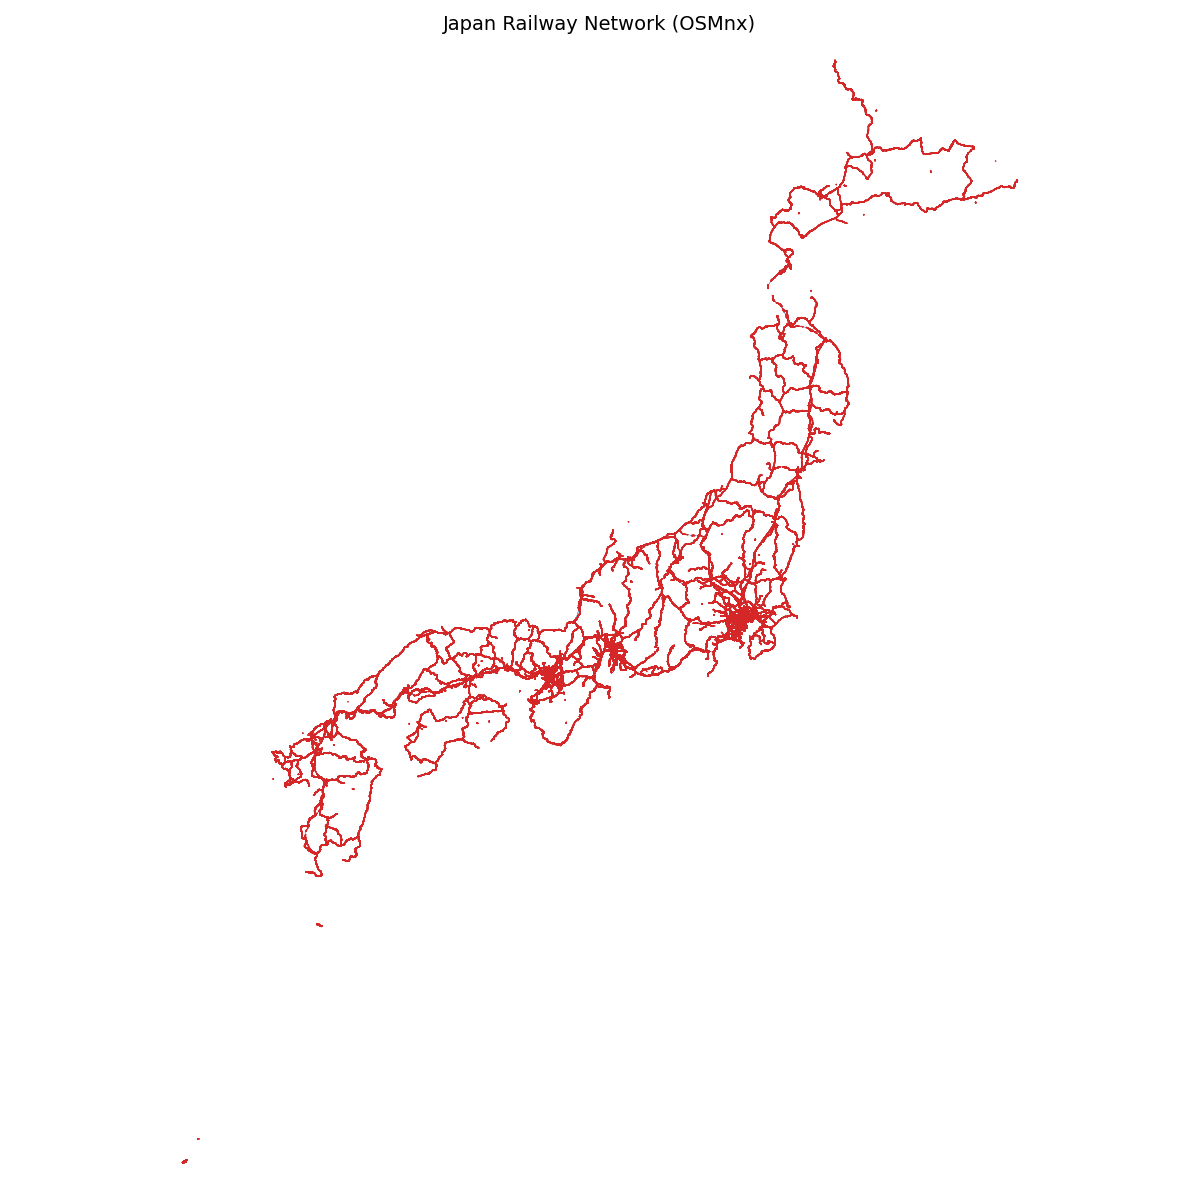

In [6]:
# Enabling interactive plots
%matplotlib widget

# Plot with osmnx - much faster than folium
fig, ax = ox.plot_graph(
    G_raw,
    figsize=(12, 12),
    node_size=1,
    node_color='#d62728',
    edge_color='#4a90d9',
    edge_linewidth=0.3,
    edge_alpha=0.7,
    node_zorder=3,
    bgcolor='white',
    show=False,
    close=False,
)
plt.title("Japan Railway Network (OSMnx)", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Simplifying the graph

In [7]:
# Simplify the graph - removes intermediate nodes, keeps only intersections/endpoints
G_simplified = ox.simplify_graph(G_raw)

# Convert to undirected for analysis
G_raw_undirected = G_raw.to_undirected()
G_simplified_undirected = G_simplified.to_undirected()

# Basic statistics
print("=" * 60)
print("GRAPH STATISTICS COMPARISON")
print("=" * 60)

print(f"\n{'Metric':<35} {'Raw':>12} {'Simplified':>12}")
print("-" * 60)
print(f"{'Nodes':<35} {G_raw.number_of_nodes():>12,} {G_simplified.number_of_nodes():>12,}")
print(f"{'Edges':<35} {G_raw.number_of_edges():>12,} {G_simplified.number_of_edges():>12,}")
print(f"{'Density':<35} {nx.density(G_raw_undirected):>12.6f} {nx.density(G_simplified_undirected):>12.6f}")

# Connected components
raw_components = list(nx.connected_components(G_raw_undirected))
simp_components = list(nx.connected_components(G_simplified_undirected))
print(f"{'Connected components':<35} {len(raw_components):>12,} {len(simp_components):>12,}")

# Largest component size
raw_largest = max(len(c) for c in raw_components)
simp_largest = max(len(c) for c in simp_components)
print(f"{'Largest component (nodes)':<35} {raw_largest:>12,} {simp_largest:>12,}")
print(f"{'Largest component (%)':<35} {raw_largest/G_raw.number_of_nodes()*100:>11.1f}% {simp_largest/G_simplified.number_of_nodes()*100:>11.1f}%")

# Degree statistics
raw_degrees = [d for _, d in G_raw_undirected.degree()]
simp_degrees = [d for _, d in G_simplified_undirected.degree()]
print(f"\n{'Average degree':<35} {np.mean(raw_degrees):>12.2f} {np.mean(simp_degrees):>12.2f}")
print(f"{'Max degree':<35} {max(raw_degrees):>12} {max(simp_degrees):>12}")
print(f"{'Min degree':<35} {min(raw_degrees):>12} {min(simp_degrees):>12}")

# Component size distribution
print(f"\n--- Component Size Distribution (Simplified) ---")
comp_sizes = sorted([len(c) for c in simp_components], reverse=True)
print(f"Top 5 components: {comp_sizes[:5]}")
print(f"Single-node components: {sum(1 for s in comp_sizes if s == 1)}")
print(f"Components with 2-10 nodes: {sum(1 for s in comp_sizes if 2 <= s <= 10)}")
print(f"Components with 11-100 nodes: {sum(1 for s in comp_sizes if 11 <= s <= 100)}")
print(f"Components with >100 nodes: {sum(1 for s in comp_sizes if s > 100)}")

GRAPH STATISTICS COMPARISON

Metric                                       Raw   Simplified
------------------------------------------------------------
Nodes                                    802,778       69,855
Edges                                  1,494,292      164,822
Edges                                  1,494,292      164,822
Density                                 0.000003     0.000035
Density                                 0.000003     0.000035
Connected components                       1,106        1,039
Largest component (nodes)                627,050       52,800
Largest component (%)                      78.1%        75.6%
Connected components                       1,106        1,039
Largest component (nodes)                627,050       52,800
Largest component (%)                      78.1%        75.6%

Average degree                              2.04         2.45
Max degree                                    10           10
Min degree                               

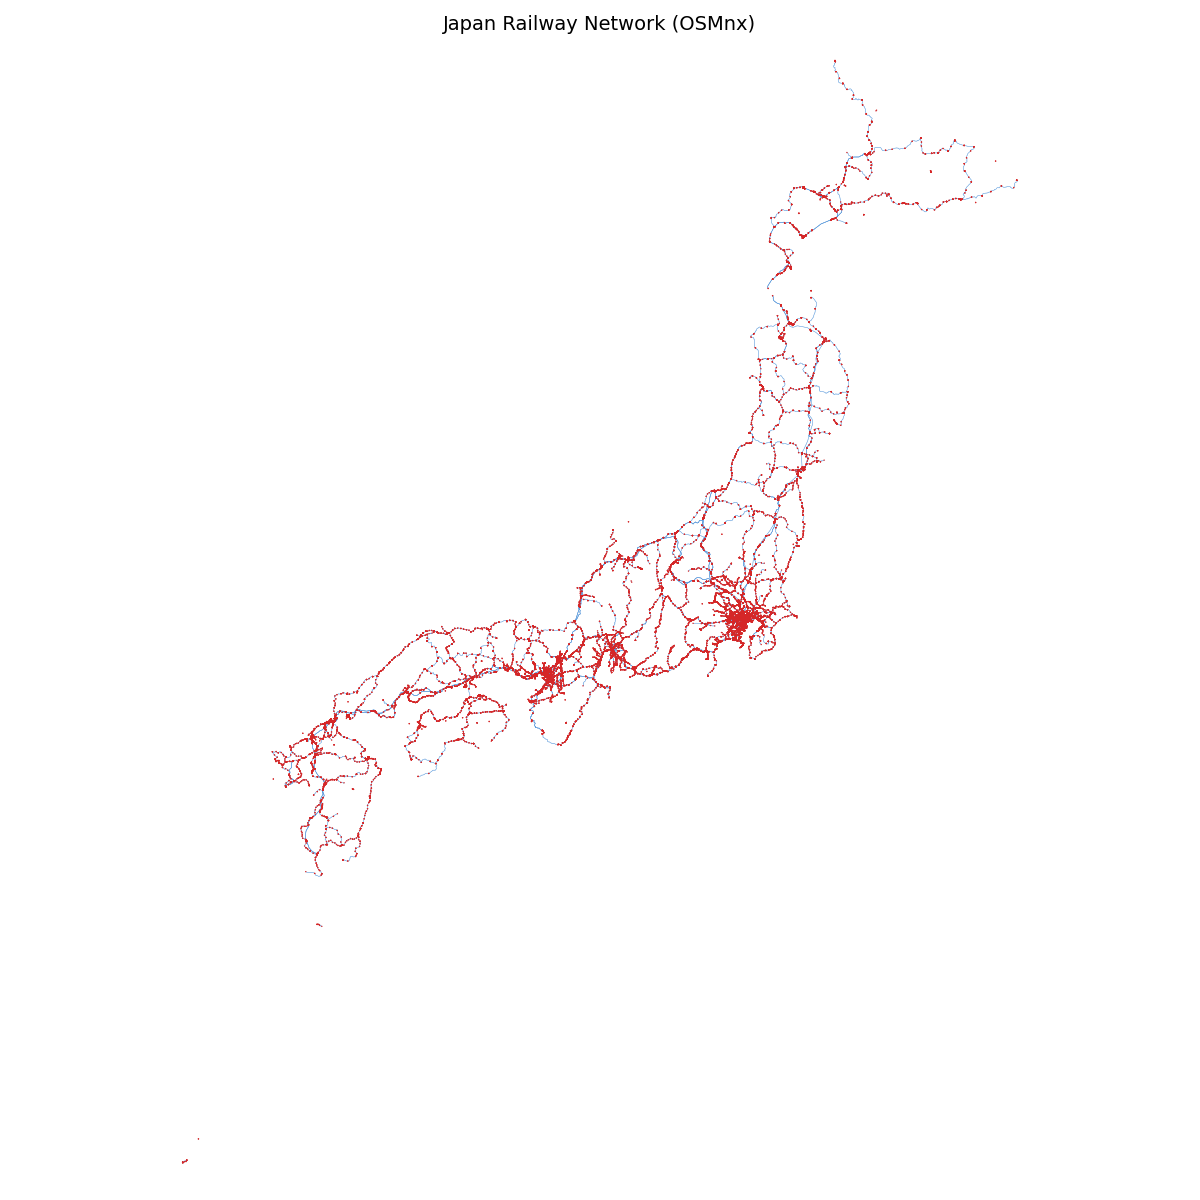

In [8]:
fig, ax = ox.plot_graph(
    G_simplified,
    figsize=(12, 12),
    node_size=1,
    node_color='#d62728',
    edge_color='#4a90d9',
    edge_linewidth=0.3,
    edge_alpha=0.7,
    node_zorder=3,
    bgcolor='white',
    show=False,
    close=False,
)
plt.title("Japan Railway Network (OSMnx)", fontsize=14)
plt.tight_layout()
plt.show()